# Логистическая регрессия

Логистическая регрессия - метод для бинарной классификации, для прогнозирования вероятности принадлежности объекта к одному из двух классов. Основывается на сигмоиде.

## Из методички

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_classification

Генерируем матрицу признаков и вектор целей. Функция make_classification генерирует случайное распределение. Число точек - 1000, кол-во признаков - 2 (оба признака влияют на целевую переменную). Класса 2 - задача бинарной  классификации.

In [3]:
X,y = make_classification (n_samples=1000,
                          n_features=2,
                          n_informative=2,
                          n_redundant=0, # число избыточных признаков
                          n_classes=2,
                          class_sep=2, # чем выше значение, тем легче разделять классы
                          random_state=1) # фиксирует случ начальное значение для генератора случ чисел

In [4]:
X.shape, y.shape

((1000, 2), (1000,))

In [5]:
pd.DataFrame(X).head()

,0,1
0,1.863411,0.087646
1,-1.530997,1.901182
2,-0.017224,-2.591112
3,-2.032039,-1.801162
4,4.620555,0.901124


Построим визуальное распределение.

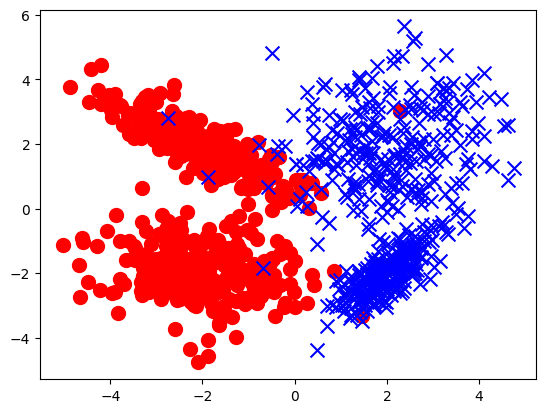

In [6]:
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o", c='r', s=100)
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="x", c='b', s=100)
plt.show()

In [7]:
class SGD(): # реализует градиентный спуск
    def __init__(self, alpha=0.5, n_iters=1000):
        self.b = None # для хранения параметров модели (например, коэф линейной регрессии)
        self._alpha = alpha
        self._n_iters = n_iters

    def gradient_step(self, b, b_grad):
        return b - self._alpha * b_grad

    def optimize(self, X, y, start_b, n_iters): # выполняет несколько шагов градиентного спуска для нахождения оптимальных параметров
        b = start_b.copy()
        for i in range(n_iters):
            b_grad = self.grad_func(X, y, b) # вычисляет градиент функции потерь
            b = self.gradient_step(b, b_grad)
        return b

    def fit(self, X, y):
        m = X.shape[1] # определяет кол-во признаков в Х
        start_b = np.ones(m) # начальные параметры модели
        self.b = self.optimize(X, y, start_b, self._n_iters)

In [8]:
class LogReg(SGD): # реализует логистическую регрессию
    def sigmoid(self, X, b):
        # сигмоида преобразует линейную комбинации признаков в вероятность (значения от 0 до 1)
        # X.dot - скалярное произведение матрицы признаков Х и вектора параметров b
        return 1. / (1. + np.exp(-X.dot(b)))

    def grad_func(self, X, y, b): # для вычисления градиента функции потерь
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, b) - y)
        return grad

    def predict_proba(self, X): # прогноз вероятностей (вычисление вероятностей принадлежности к положительному классу)
        return self.sigmoid(X, self.b)

    def predict(self, X): # прогнозирование классов (бинарная классификация на основе вероятностей)
        y_pred = self.predict_proba(X) > 0.5
        return y_pred

In [9]:
logreg = LogReg()

Добавляем фиктивный столбец единиц к матрице признаков Х.

In [10]:
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
# X.shape[0] - кол-во строк в матрице признаков Х
# np.ones(..) - создает вектор длины, равной кол-ву строк в Х, и заполняет 1
# [;, np.newaxis] - преобразует вектор единиц в двумерный столбец
# hstack - матрица Х будет дополнена столбцом единиц в начале, чтобы учитывать сдвиг при обучении (свободный член)

In [11]:
logreg.fit(X, y)
y_pred = logreg.predict(X)

In [12]:
from sklearn.metrics import accuracy_score, f1_score
ac = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
print(f'accuracy = {ac:.2f} F1-score = {f1:.2f}')

accuracy = 0.98 F1-score = 0.98


In [13]:
y_pred_proba = logreg.predict_proba(X)

Создаем двумерную матрицу, содержащую все комбинации значений признаков в заданном диапазоне. (для построения контурного графика)

In [14]:
xx, yy = np.meshgrid(
    np.arange(X.min(axis=0)[1]-1, X.max(axis=0)[1]+1, 0.01),
    np.arange(X.min(axis=0)[2]-1, X.max(axis=0)[2]+1, 0.01)) # создает двумерные массивы хх и уу - содержат координаты точек по осям х и у
XX = np.array(list(zip(xx.ravel(), yy.ravel()))).reshape((-1, 2)) # объединяет эти координаты в одномерные пары и преобразует в двумерный массив хх
XX = np.array([(1, *xx) for xx in XX]) # добавляет столбец единиц

In [15]:
Z = logreg.predict_proba(XX)
Z = Z.reshape(xx.shape)

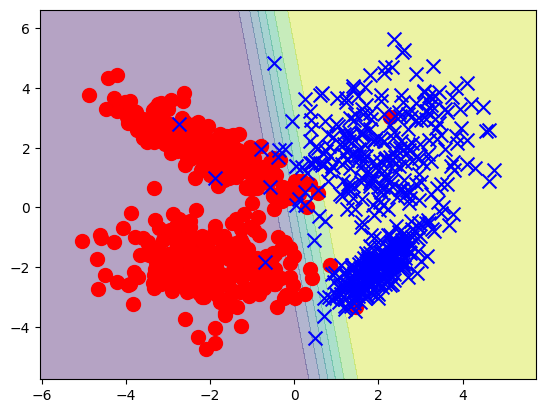

In [16]:
# Контурный график показывает вероятности принадлежности точек сетки к классу 1
# и отображает реальные данные (красные круги - класс 0, синие крестики - класс 1)

plt.contourf(xx, yy, Z, alpha=0.4)
# хх, уу - координаты точек сетки
# Z - предсказания модели для каждой точки в сетке
# alpha - чем ниже значение, тем более прозрачный будет график
plt.scatter(X[:, 1][y==0], X[:, 2][y==0], marker="o", c='r', s=100)
plt.scatter(X[:, 1][y==1], X[:, 2][y==1], marker="x", c='b', s=100)

## Задания для самостоятельного выполнения

*1. Выведите результаты работы библиотечной модели - в численном и в графическом виде.*

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
# создание и обучение модели
model = LogisticRegression()
model.fit(X, y)

# предсказание
y_pred_lr = model.predict(X)
y_pred_proba_lr = model.predict_proba(X)[:, 1]

# оценка качества
accuracy = accuracy_score(y, y_pred_lr)
f1 = f1_score(y, y_pred_lr)
print(f'Accuracy = {accuracy:.2f}, F1-score = {f1:.2f}')

Accuracy = 0.98, F1-score = 0.98


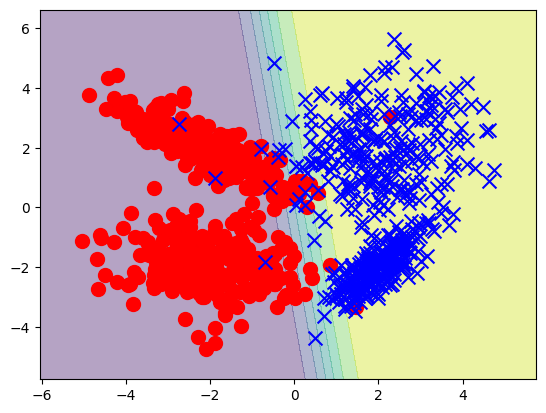

In [19]:
# создание сетки
xx, yy = np.meshgrid(
    np.arange(X[:, 1].min()-1, X[:, 1].max()+1, 0.01), # диапазон по первой оси
    np.arange(X[:, 2].min()-1, X[:, 2].max()+1, 0.01) # диапазон по второй оси
)

XX = np.c_[np.ones(xx.ravel().shape[0]), xx.ravel(), yy.ravel()] # фиктивный столбец единиц

Z = model.predict_proba(XX)[:, 1].reshape(xx.shape) # веротяности принадлежности к классу 1

# контурный график
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 1][y == 0], X[:, 2][y == 0], marker="o", c='r', s=100)
plt.scatter(X[:, 1][y == 1], X[:, 2][y == 1], marker="x", c='b', s=100)
plt.show()


*2. Проверьте работу модели с другими значениями скорости обучения. Найдите значение, при котором градиентный спуск расходится.*

In [20]:
alphas = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]  # скорости обучения
accuracies = []
f1_scores = []

for alpha in alphas:
    logreg = LogReg(alpha=alpha, n_iters=1000)
    try:
        logreg.fit(X, y) # если градиентный спуск не сойдется (например, при слишком большом alpha)
        #, возникнет ошибка
        y_pred = logreg.predict(X)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        accuracies.append(acc)
        f1_scores.append(f1)
        print(f"alpha = {alpha}: Accuracy = {acc:.2f}, F1-score = {f1:.2f}")
    except Exception as e:
        print(f"alpha = {alpha}: Расходится (ошибка: {e})")
        accuracies.append(None)
        f1_scores.append(None)


alpha = 0.001: Accuracy = 0.92, F1-score = 0.92
alpha = 0.01: Accuracy = 0.97, F1-score = 0.97
alpha = 0.1: Accuracy = 0.98, F1-score = 0.98
alpha = 0.5: Accuracy = 0.98, F1-score = 0.98
alpha = 1: Accuracy = 0.98, F1-score = 0.98
alpha = 5: Accuracy = 0.98, F1-score = 0.98
alpha = 10: Accuracy = 0.98, F1-score = 0.98


*3. Модифицируйте код модели таким образом, чтобы фиктивный столбец единиц добавлялся к матрице признаков внутри класса.*

In [21]:
class SGD():
    def __init__(self, alpha=0.5, n_iters=1000):
        self.b = None
        self._alpha = alpha
        self._n_iters = n_iters

    def gradient_step(self, b, b_grad):
        return b - self._alpha * b_grad

    def optimize(self, X, y, start_b, n_iters):
        b = start_b.copy()
        for i in range(n_iters):
            b_grad = self.grad_func(X, y, b)
            b = self.gradient_step(b, b_grad)
        return b

    def fit(self, X, y):
        X = np.hstack([np.ones((X.shape[0], 1)), X])  # единичный столбец
        m = X.shape[1]
        start_b = np.ones(m)
        self.b = self.optimize(X, y, start_b, self._n_iters)

In [22]:
class LogReg(SGD):
    def sigmoid(self, X, b):
        return 1. / (1. + np.exp(-X.dot(b)))

    def grad_func(self, X, y, b):
        n = X.shape[0]
        grad = 1. / n * X.T.dot(self.sigmoid(X, b) - y)
        return grad

    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])  # единичный столбец
        return self.sigmoid(X, self.b)

    def predict(self, X):
        return self.predict_proba(X) > 0.5

In [23]:
# пример использования
logreg = LogReg(alpha=0.1, n_iters=1000)
logreg.fit(X, y)

y_pred = logreg.predict(X)

print(f"Accuracy: {accuracy_score(y, y_pred):.2f}")
print(f"F1-score (macro): {f1_score(y, y_pred, average='macro'):.2f}")
# average='micro' - учитывает все классы одинаково
# average='macro' - усредняет F1-score по классам
# average='weighted' - учитывает размер классов при усреднении

Accuracy: 0.98
F1-score (macro): 0.98


*4. Поэкспериментируйте с разными значениями параметра class_sep при генерации датасета. Визуализируйте полученные распределения. Сделайте вывод о том, как этот параметр влияет на точность получаемых моделей.*

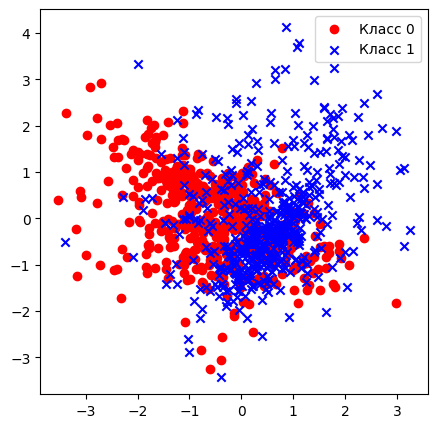

class_sep = 0.5 -> Accuracy: 0.71, F1-score: 0.71



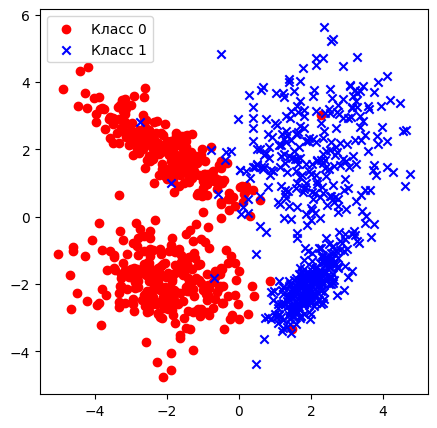

class_sep = 2 -> Accuracy: 0.98, F1-score: 0.98



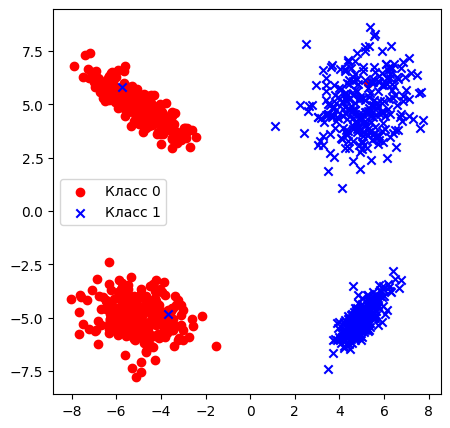

class_sep = 5 -> Accuracy: 1.00, F1-score: 1.00



In [24]:
def experiment_class_sep(class_sep):
    X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                               n_redundant=0, n_classes=2, class_sep=class_sep, random_state=1)

    plt.figure(figsize=(5, 5)) # создается график 5 на 5
    plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], marker="o", c='r', label="Класс 0")
    plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], marker="x", c='b', label="Класс 1")
    plt.legend()
    plt.show()

    logreg = LogReg(alpha=0.1, n_iters=1000)
    logreg.fit(X, y)
    y_pred = logreg.predict(X)

    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print(f"class_sep = {class_sep} -> Accuracy: {acc:.2f}, F1-score: {f1:.2f}\n")

# запуск экспериментов с разными class_sep
for sep in [0.5, 2, 5]:
    experiment_class_sep(sep)


При низком class_sep (при 0.5) классы плохо разделяются. Модель имеет низкую точность и f1-score, граница раздлеления - нечеткая.

При умеренном class_sep (при 2) классы становятся более различимыми, модель достигает более высокой точности.

При высоком class_sep (при 5) классы почти полностью разделены, модель достигает идеальной точности, данные линейно разделимы.

*5. Сгенерируйте датасет с большим числом признаков и примените к нему созданную модель.*

In [25]:
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5,
                           n_redundant=2, n_classes=2, random_state=1) # с 10 признаками

logreg = LogReg(alpha=0.1, n_iters=1000)
logreg.fit(X, y)
y_pred = logreg.predict(X)

acc = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)

print(f"Accuracy: {acc:.2f}, F1-score: {f1:.2f}")


Accuracy: 0.82, F1-score: 0.81


*6. Сгенерируйте датасет с большим количеством классов и реализуйте в классе алгоритм "один против всех". Решите задачу множественной классификации средствами sklearn.*

In [26]:
X, y = make_classification(n_samples=1000, n_features=5, n_informative=3,
                           n_redundant=1, n_classes=4, random_state=1) # с 4 классами


In [27]:
class LogRegOAA:
    def __init__(self, alpha=0.1, n_iters=1000):
        self.models = [] # обученные модели логистической регрессии для каждого класса
        self.alpha = alpha
        self.n_iters = n_iters

    def fit(self, X, y):
        self.classes = np.unique(y) # уникальные классы в целевой переменной
        for cls in self.classes:
            # бинарная классификация, объекты класса cls получают метку 1, остальные - 0
            y_binary = (y == cls).astype(int)
            model = LogReg(alpha=self.alpha, n_iters=self.n_iters)
            model.fit(X, y_binary)
            self.models.append(model)

    def predict(self, X):
        probs = np.array([model.predict_proba(X) for model in self.models]).T
        return np.argmax(probs, axis=1)  # класс с наибольшей вероятностью


In [28]:
logreg_oaa = LogRegOAA(alpha=0.1, n_iters=1000)
logreg_oaa.fit(X, y)
y_pred = logreg_oaa.predict(X)

acc = accuracy_score(y, y_pred)
print(f"Accuracy (LogReg one against all): {acc:.2f}")


Accuracy (LogReg one against all): 0.77


In [29]:
model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000)
model.fit(X, y)
y_pred_sklearn = model.predict(X)

acc_sklearn = accuracy_score(y, y_pred_sklearn)
print(f"Accuracy (sklearn): {acc_sklearn:.2f}")


Accuracy (sklearn): 0.78


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


*7. Выведите значения вероятностей для каждого объекта принадлежать тому или иному классу для библиотечной модели LogisticRegression.*

In [30]:
y_pred_proba = model.predict_proba(X)

df_proba = pd.DataFrame(y_pred_proba, columns=[f'Class_{cls}' for cls in model.classes_])
print(df_proba.head())


    Class_0   Class_1   Class_2   Class_3
0  0.716546  0.197113  0.063177  0.023165
1  0.446736  0.379792  0.056075  0.117397
2  0.863845  0.022099  0.105610  0.008446
3  0.141613  0.021165  0.465581  0.371641
4  0.205361  0.628601  0.020740  0.145299
